In [12]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException


In [36]:
SEC_SOURCE_URL = "https://www.sec.gov/Archives/edgar/full-index/"

In [40]:
chrome_options = webdriver.ChromeOptions()
prefs = {'download.default_directory' : 'data/index'}
chrome_options.add_experimental_option('prefs', prefs)
driver = webdriver.Chrome(f'/Users/rudra/Library/CloudStorage/OneDrive-Personal/Documents/Analytical_Finance_ML/inflation_trading/chromedriver', chrome_options=chrome_options)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/504268545.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(f'/Users/rudra/Library/CloudStorage/OneDrive-Personal/Documents/Analytical_Finance_ML/inflation_trading/chromedriver', chrome_options=chrome_options)
/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/504268545.py:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(f'/Users/rudra/Library/CloudStorage/OneDrive-Personal/Documents/Analytical_Finance_ML/inflation_trading/chromedriver', chrome_options=chrome_options)


In [41]:
driver.get(SEC_SOURCE_URL)

In [42]:
elems = driver.find_elements(By.XPATH, "//a[@href]")
links = []
for elem in elems:
    links.append(elem.get_attribute("href"))

In [43]:
# find all links that contain digits in list links
import re
regexp = re.compile(r'\d')
links = [link for link in links if regexp.search(link)]

In [44]:
index_links = [link + qtr + "/company.idx" for link in links for qtr in ["QTR1", "QTR2", "QTR3", "QTR4"] ]

In [45]:
index_links

['https://www.sec.gov/Archives/edgar/full-index/1993/QTR1/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1993/QTR2/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1993/QTR3/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1993/QTR4/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1994/QTR1/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1994/QTR2/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1994/QTR3/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1994/QTR4/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1995/QTR1/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1995/QTR2/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1995/QTR3/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1995/QTR4/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1996/QTR1/company.idx',
 'https://www.sec.gov/Archives/edgar/full-index/1996/QTR2/compan

In [61]:
# set random user agent to avoid 403 error and download index files from index links and save in data/index folder

import random
from fake_useragent import UserAgent
ua = UserAgent()

for link in index_links:
    try:
        user_agent = ua.random
        headers = {'User-Agent': user_agent}
        r = requests.get(link, headers=headers)
        with open("data/index/" + "_".join(link.split("/")[-3:]), 'wb') as f:
            f.write(r.content)
    except Exception as e:
        print("Error: ", link)
        print("Exception", e)

In [391]:

import os
import re

index_files = os.listdir("data/index")
index_files = [file for file in index_files if file.endswith(".idx")]

links = []
for file in index_files:
    with open("data/index/" + file, 'r') as f:
        # clean index file to remove all lines that do not contain 10k
        # read lines with utf-8 encoding

        try:
            lines = f.readlines()
            lines = [line for line in lines if "10-K" in line]
            # replace more than one space with | and split on |
            lines = [re.sub(r'\s{2,}', '|', line).split("|") for line in lines]
        
            # for each line, save first element as company name, second element as filling type, third element as CIK, fourth element as file
            for line in lines:
                links.append(line)
            
        except UnicodeDecodeError:
            continue 

In [392]:
# save list of lists in a dataframe
df = pd.DataFrame(links)

In [393]:
df

,0,1,2,3,4,5,6,7,8
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,,None,None,None
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt,,None,None,None
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt,,None,None,None
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt,,None,None,None
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt,,None,None,None
...,...,...,...,...,...,...,...,...,...
217537,"iGenii, Inc.",10-K,1441573,2012-07-09,edgar/data/1441573/0001188112-12-002130.txt,,None,None,None
217538,"iGenii, Inc.",10-K/A,1441573,2012-07-20,edgar/data/1441573/0001188112-12-002198.txt,,None,None,None
217539,iMetrik M2M Solutions Inc.,10-K,1466739,2012-08-29,edgar/data/1466739/0001002014-12-000470.txt,,None,None,None
217540,iMetrik M2M Solutions Inc.,10-K/A,1466739,2012-07-27,edgar/data/1466739/0001002014-12-000398.txt,,None,None,None


In [394]:
# see unique values in column 8
df[7].unique()

array([None, '', 'edgar/data/1236966/0001056404-04-001080.txt'],
      dtype=object)

In [395]:
# replace '' with none
df = df.replace('', None)

In [396]:
df[df[7] == 'edgar/data/1236966/0001056404-04-001080.txt']

,0,1,2,3,4,5,6,7,8
167503,MORTGAGE ASSET SEC TRANS,ALTER,LN,SER 2003-4,10-K,1236966,2004-03-30,edgar/data/1236966/0001056404-04-001080.txt,None


In [397]:
# get column number of last non na value in each row
df["last_valid_index"] = df.apply(lambda x: x.last_valid_index(), axis=1)

In [398]:
df

,0,1,2,3,4,5,6,7,8,last_valid_index
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,None,None,None,None,4
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt,None,None,None,None,4
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt,None,None,None,None,4
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt,None,None,None,None,4
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt,None,None,None,None,4
...,...,...,...,...,...,...,...,...,...,...
217537,"iGenii, Inc.",10-K,1441573,2012-07-09,edgar/data/1441573/0001188112-12-002130.txt,None,None,None,None,4
217538,"iGenii, Inc.",10-K/A,1441573,2012-07-20,edgar/data/1441573/0001188112-12-002198.txt,None,None,None,None,4
217539,iMetrik M2M Solutions Inc.,10-K,1466739,2012-08-29,edgar/data/1466739/0001002014-12-000470.txt,None,None,None,None,4
217540,iMetrik M2M Solutions Inc.,10-K/A,1466739,2012-07-27,edgar/data/1466739/0001002014-12-000398.txt,None,None,None,None,4


In [399]:
restruct_df = df[df["last_valid_index"] > 4]

In [400]:
restruct_df.shape

(413, 10)

In [401]:
restruct_df[restruct_df["last_valid_index"] == 6]

,0,1,2,3,4,5,6,7,8,last_valid_index
11744,STRATS,SM TRUST FOR,AT&T CORP SEC SER 2004-4,10-K,1281120,2009-03-30,edgar/data/1281120/0000905148-09-001374.txt,None,None,6
11777,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,FUND,NTS,10-K,1274365,2009-03-24,edgar/data/1274365/0001282695-09-000063.txt,None,None,6
17645,ACE SECURITIES CORP HOME EQUITY,LN,TR SER 2001-HE1,10-K,1162641,2002-03-27,edgar/data/1162641/0001056404-02-000463.txt,None,None,6
21827,PRIME HOLDINGS &,INVESTMENTS,INC,NT 10-K,1111882,2002-03-27,edgar/data/1111882/0001056520-02-000030.txt,None,None,6
30459,STRATS,SM TRUST FOR,AT&T CORP SEC SER 2004-4,10-K,1281120,2006-03-31,edgar/data/1281120/0000905148-06-003014.txt,None,None,6
30510,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,FUND,NTS,10-K,1274365,2006-03-30,edgar/data/1274365/0001282695-06-000240.txt,None,None,6
33848,PRIME HOLDINGS &,INVESTMENTS,INC,NT 10-K,1111882,2003-04-01,edgar/data/1111882/0000930413-03-001049.txt,None,None,6
61273,STRATS,SM TRUST FOR,AT&T CORP SEC SER 2004-4,10-K,1281120,2008-03-28,edgar/data/1281120/0000905148-08-001918.txt,None,None,6
61306,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,FUND,NTS,10-K,1274365,2008-03-26,edgar/data/1274365/0001282695-08-000080.txt,None,None,6
104925,STRATS,SM TRUST FOR,AT&T CORP SEC SER 2004-4,10-K,1281120,2007-03-30,edgar/data/1281120/0000905148-07-002957.txt,None,None,6


In [402]:
fixed_df = pd.DataFrame()
for idx, row in restruct_df.iterrows():
    # move the difference between last_valid_index and of each column except column 0 to difference value
    difference = row["last_valid_index"] - 4
    for i in range(2, row["last_valid_index"] + 1):
        row[i - 1] = row[i]

    # make all rows greater than last_valid_index as None
    for i in range(row["last_valid_index"], len(row)):
        row[i] = None

    # add row to dataframe
    fixed_df = fixed_df.append(row, ignore_index=True)
    
fixed_df["last_valid_index"] = 4

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/1965370177.py:10: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  row[i] = None
/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/1965370177.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fixed_df = fixed_df.append(row, ignore_index=True)


In [403]:
fixed_df

,0,1,2,3,4,5,6,7,8,last_valid_index
0,ATLAS AMERICA PUBLIC,10-K,1157516,2009-03-30,edgar/data/1157516/0001279228-09-000026.txt,None,None,None,None,4
1,AUTOBYTEL,10-K,1023364,2009-03-13,edgar/data/1023364/0001193125-09-052623.txt,None,None,None,None,4
2,CEVA,10-K,1173489,2009-03-13,edgar/data/1173489/0001362310-09-003696.txt,None,None,None,None,4
3,FORGENT NETWORKS,10-K/A,884144,2009-01-27,edgar/data/884144/0001104659-09-004370.txt,None,None,None,None,4
4,HAWAIIAN HOLDINGS,10-K,1172222,2009-02-26,edgar/data/1172222/0001047469-09-001839.txt,None,None,None,None,4
...,...,...,...,...,...,...,...,...,...,...
408,STRUCTURED PRODUCTS CORP TIERS PP ASSET BK SER...,10-K,1281815,2005-03-30,edgar/data/1281815/0001282695-05-000426.txt,None,None,None,None,4
409,SYNOVIS LIFE TECHNOLOGIES,10-K,780127,2005-01-14,edgar/data/780127/0000950134-05-000756.txt,None,None,None,None,4
410,WACHOVIA COMMERCIAL MORT SEC INC,10-K,1220670,2005-03-30,edgar/data/1220670/0001056404-05-001504.txt,None,None,None,None,4
411,ZYNEX MEDICAL HOLDINGS,NT 10-K,846475,2005-03-31,edgar/data/846475/0001079974-05-000117.txt,None,None,None,None,4


In [404]:
fixed_df.isna().sum()

0                     0
1                     0
2                     0
3                     0
4                     0
5                   394
6                   412
7                   413
8                   413
last_valid_index      0
dtype: int64

In [405]:
# drop rows that are in restruct_df in df
df = df.drop(restruct_df.index)

In [406]:
# append fixed_df to df
df = df.append(fixed_df, ignore_index=True)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/1746816023.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fixed_df, ignore_index=True)


In [407]:
df.shape

(217542, 10)

In [408]:
# find rows that are not na in column 5 and 6
df[df[5].notna() | df[6].notna()]

,0,1,2,3,4,5,6,7,8,last_valid_index
217141,STRATS,AT&T CORP SEC SER 2004-4,10-K,1281120,2009-03-30,edgar/data/1281120/0000905148-09-001374.txt,None,None,None,4
217142,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,NTS,10-K,1274365,2009-03-24,edgar/data/1274365/0001282695-09-000063.txt,None,None,None,4
217147,ACE SECURITIES CORP HOME EQUITY,TR SER 2001-HE1,10-K,1162641,2002-03-27,edgar/data/1162641/0001056404-02-000463.txt,None,None,None,4
217170,PRIME HOLDINGS &,INC,NT 10-K,1111882,2002-03-27,edgar/data/1111882/0001056520-02-000030.txt,None,None,None,4
217199,STRATS,AT&T CORP SEC SER 2004-4,10-K,1281120,2006-03-31,edgar/data/1281120/0000905148-06-003014.txt,None,None,None,4
217200,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,NTS,10-K,1274365,2006-03-30,edgar/data/1274365/0001282695-06-000240.txt,None,None,None,4
217232,PRIME HOLDINGS &,INC,NT 10-K,1111882,2003-04-01,edgar/data/1111882/0000930413-03-001049.txt,None,None,None,4
217258,STRATS,AT&T CORP SEC SER 2004-4,10-K,1281120,2008-03-28,edgar/data/1281120/0000905148-08-001918.txt,None,None,None,4
217259,STRUCTURED PROD CORP CORTS TR II FOR VERIZON GLOB,NTS,10-K,1274365,2008-03-26,edgar/data/1274365/0001282695-08-000080.txt,None,None,None,4
217312,STRATS,AT&T CORP SEC SER 2004-4,10-K,1281120,2007-03-30,edgar/data/1281120/0000905148-07-002957.txt,None,None,None,4


In [409]:
df.dropna(axis=1, inplace=True)

In [410]:
df.head()

,0,1,2,3,4,last_valid_index
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,4
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt,4
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt,4
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt,4
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt,4


In [411]:
df

,0,1,2,3,4,last_valid_index
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,4
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt,4
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt,4
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt,4
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt,4
...,...,...,...,...,...,...
217537,STRUCTURED PRODUCTS CORP TIERS PP ASSET BK SER...,10-K,1281815,2005-03-30,edgar/data/1281815/0001282695-05-000426.txt,4
217538,SYNOVIS LIFE TECHNOLOGIES,10-K,780127,2005-01-14,edgar/data/780127/0000950134-05-000756.txt,4
217539,WACHOVIA COMMERCIAL MORT SEC INC,10-K,1220670,2005-03-30,edgar/data/1220670/0001056404-05-001504.txt,4
217540,ZYNEX MEDICAL HOLDINGS,NT 10-K,846475,2005-03-31,edgar/data/846475/0001079974-05-000117.txt,4


In [412]:
df = df.drop("last_valid_index", axis=1)

In [413]:
# add column names to dataframe
df.columns = ["company_name", "filling_type", "cik", "date", "file"]

In [414]:
df

,company_name,filling_type,cik,date,file
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt
...,...,...,...,...,...
217537,STRUCTURED PRODUCTS CORP TIERS PP ASSET BK SER...,10-K,1281815,2005-03-30,edgar/data/1281815/0001282695-05-000426.txt
217538,SYNOVIS LIFE TECHNOLOGIES,10-K,780127,2005-01-14,edgar/data/780127/0000950134-05-000756.txt
217539,WACHOVIA COMMERCIAL MORT SEC INC,10-K,1220670,2005-03-30,edgar/data/1220670/0001056404-05-001504.txt
217540,ZYNEX MEDICAL HOLDINGS,NT 10-K,846475,2005-03-31,edgar/data/846475/0001079974-05-000117.txt


In [415]:
# find record that does not have a dash in the date column
df = df[df["date"].str.contains("-")]

In [416]:
df = df[df["filling_type"].str.contains("-")]

In [417]:
df = df[~df["cik"].str.contains("-")]

In [418]:
df

,company_name,filling_type,cik,date,file
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt
2,3AM TECHNOLOGIES INC,NT 10-K,1667615,2020-08-31,edgar/data/1667615/0001078782-20-000675.txt
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt
...,...,...,...,...,...
217537,STRUCTURED PRODUCTS CORP TIERS PP ASSET BK SER...,10-K,1281815,2005-03-30,edgar/data/1281815/0001282695-05-000426.txt
217538,SYNOVIS LIFE TECHNOLOGIES,10-K,780127,2005-01-14,edgar/data/780127/0000950134-05-000756.txt
217539,WACHOVIA COMMERCIAL MORT SEC INC,10-K,1220670,2005-03-30,edgar/data/1220670/0001056404-05-001504.txt
217540,ZYNEX MEDICAL HOLDINGS,NT 10-K,846475,2005-03-31,edgar/data/846475/0001079974-05-000117.txt


In [420]:
# get min date
df["date"] = pd.to_datetime(df["date"])
print(df["date"].min())
print(df["date"].max())

1993-10-07 00:00:00
2023-02-06 00:00:00


In [421]:
tenK_df = df[df["filling_type"] == "10-K"]

In [422]:
tenK_df.shape

(139723, 5)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/1027854134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tenK_df["year"] = tenK_df["date"].dt.year
/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_14745/1027854134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tenK_df["month"] = tenK_df["date"].dt.month


<AxesSubplot:>

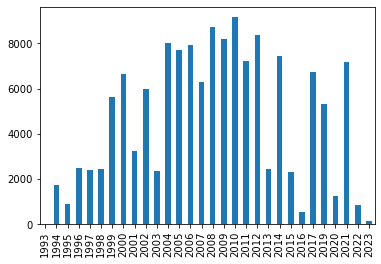

In [427]:
tenK_df["year"] = tenK_df["date"].dt.year
tenK_df["month"] = tenK_df["date"].dt.month

# get a histogram of count of records by year
tenK_df["year"].value_counts().sort_index().plot(kind="bar")

In [429]:
tenK_df

,company_name,filling_type,cik,date,file,year,month
0,1 800 FLOWERS COM INC,10-K,1084869,2020-09-11,edgar/data/1084869/0001437749-20-019622.txt,2020,9
1,3AM TECHNOLOGIES INC,10-K,1667615,2020-09-14,edgar/data/1667615/0001078782-20-000695.txt,2020,9
3,8i Enterprises Acquisition Corp.,10-K,1753648,2020-09-15,edgar/data/1753648/0001493152-20-017860.txt,2020,9
4,"A-Mark Precious Metals, Inc.",10-K,1591588,2020-09-14,edgar/data/1591588/0001564590-20-043316.txt,2020,9
5,AAR CORP,10-K,1750,2020-07-21,edgar/data/1750/0001104659-20-085310.txt,2020,7
...,...,...,...,...,...,...,...
217536,STRUCTURED PRODUCTS CORP,10-K,1281822,2005-03-30,edgar/data/1281822/0001282695-05-000430.txt,2005,3
217537,STRUCTURED PRODUCTS CORP TIERS PP ASSET BK SER...,10-K,1281815,2005-03-30,edgar/data/1281815/0001282695-05-000426.txt,2005,3
217538,SYNOVIS LIFE TECHNOLOGIES,10-K,780127,2005-01-14,edgar/data/780127/0000950134-05-000756.txt,2005,1
217539,WACHOVIA COMMERCIAL MORT SEC INC,10-K,1220670,2005-03-30,edgar/data/1220670/0001056404-05-001504.txt,2005,3


In [822]:
tenK_df.to_csv("10k_txt_links.csv", index=False)

In [809]:
# find companies that have the word "apple" in their name and in 2021
tenK_df[(tenK_df["company_name"].str.contains("apple", case=False)) & (tenK_df["year"] == 2021)]

,company_name,filling_type,cik,date,file,year,month
126669,"Apple Hospitality REIT, Inc.",10-K,1418121,2021-02-23,edgar/data/1418121/0001564590-21-007573.txt,2021,2
129596,MAUI LAND & PINEAPPLE CO INC,10-K,63330,2021-03-02,edgar/data/63330/0001437749-21-004630.txt,2021,3
130325,"PINEAPPLE, INC.",10-K,1654672,2021-02-16,edgar/data/1654672/0001493152-21-003729.txt,2021,2
170628,Apple Inc.,10-K,320193,2021-10-29,edgar/data/320193/0000320193-21-000105.txt,2021,10
171045,"PINEAPPLE, INC.",10-K,1654672,2021-10-04,edgar/data/1654672/0001493152-21-024497.txt,2021,10


In [690]:
# get html text from 10k link with random user agent
import random
from fake_useragent import UserAgent
ua = UserAgent()

def get_html(link):
    link = "https://www.sec.gov/Archives/"+ link
    user_agent = ua.random
    print(user_agent)
    headers = {'User-Agent': "Mozilla/5.0"}
    r = requests.get(link, headers=headers)
    if r.status_code == 200: 
        # The HTTP 200 OK success status response code indicates that the request has succeeded. 
        return r
    
    return "Error"

In [810]:
#tenK_html = get_html("edgar/data/886982/0001193125-21-049380.txt")
tenK_html = get_html('edgar/data/320193/0000320193-21-000105.txt')


Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML like Gecko) Chrome/51.0.2704.79 Safari/537.36 Edge/14.14931


In [811]:
#tenK_html.content.decode("utf-8").split('  ')

In [812]:
soup = BeautifulSoup(tenK_html.content, 'html.parser')

In [813]:
# get text from html
text = soup.get_text()

In [814]:
# save text to temp file
with open("temp.txt", 'w') as f:
    f.write(text)

In [815]:
# get all spans that contain the word "item" and does not have an a tag
# items = [i for i in soup.find_all("span", string=re.compile("Item", re.IGNORECASE)) if i.find("a") == None]

items = [i for i in soup.find_all("span", string=re.compile("^Item", re.IGNORECASE)) if i.find("a") == None and i.parent.name == "div"]
tag = "span"

if len(items) < 3:
    items = [i for i in soup.find_all("div", string=re.compile("^Item", re.IGNORECASE)) if i.find("a") == None and i.parent.name == "div"]
    tag = "div"


In [816]:
items

[<span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1.    Business</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1A.    Risk Factors</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1B.    Unresolved Staff Comments</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 2.    Properties</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 3.    Legal Proceedings</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 4.    Mine Safety Disclosures</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 5

In [795]:
import collections

d = collections.OrderedDict()

for i,v in enumerate(items):
    d[v.text] = i


In [796]:
# keep only items that are in list of indices
items = [items[i] for i in d.values()]

In [797]:
items

[<div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 1</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 1A</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 1B</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 2</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 3</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 4</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 5</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inline;">Item 7</div>,
 <div style="font-family: ARIAL; font-size: 8.5pt; letter-spacing: 0px; top: 0px;;display:inli

In [749]:
# find the spring

In [750]:
# tag to string

In [817]:
# get all the text between 2 different span tags
def get_text_between_tags(soup, start_tag, end_tag, tag):   
        
    start_text = start_tag.text
    end_text = end_tag.text

    start = soup.find(tag, string=start_text).parent
    end = soup.find(tag, string=end_text).parent
    print(start)
    print(end)
    text = ""
    while start != end:
        if start != None:
            text += start.text
            start = start.find_all_next("div")[0]
        else:
            break
    return text

In [818]:
items[3]

<span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 2.    Properties</span>

In [819]:
#2021
#apple: works
#disney: works
#amazon: half are td tags, half are div tags....what shit

In [820]:
import string
import unidecode

# create a loop to get all the text between each item
item_dict = {}
for i in range(len(items) - 1):
    start_item = items[i]
    end_item = items[i + 1]

    # get the second word in the item
    item_number = start_item.text.split()[1]
    print(start_item.text.split())
    #remove all punctuation from item number
    item_number = item_number.translate(str.maketrans('', '', string.punctuation))
    print(item_number)
    
    raw = get_text_between_tags(soup, start_item, end_item, tag)
    
    # remove all punctuation from raw text
    raw = raw.translate(str.maketrans('', '', string.punctuation))

    # remove escape characters using regex
    cleaned = re.sub(r'\\n', ' ', raw)
    cleaned = re.sub(r'\\t', ' ', cleaned)
    cleaned = re.sub(r'\\r', ' ', cleaned)
    cleaned = re.sub(r'\\', ' ', cleaned)
    cleaned = unidecode.unidecode(cleaned)

    # remove extra spaces
    cleaned = re.sub(' +', ' ', cleaned)

    # if exists in dict, append to existing value
    if item_number in item_dict:
        item_dict[item_number] += cleaned
    else:
        item_dict[item_number] = cleaned

['Item', '1.', 'Business']
1
<div style="margin-top:12pt;padding-left:45pt;text-align:justify;text-indent:-45pt"><span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1.    Business</span></div>
<div style="padding-left:45pt;text-align:justify;text-indent:-45pt"><span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1A.    Risk Factors</span></div>
['Item', '1A.', 'Risk', 'Factors']
1A
<div style="padding-left:45pt;text-align:justify;text-indent:-45pt"><span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1A.    Risk Factors</span></div>
<div style="margin-top:18pt;padding-left:45pt;text-align:justify;text-indent:-45pt"><span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:700;line-height:120%">Item 1B.    Unresolved Staff Comments</span></div>
['Item', '1B.', 'Unresolved',

In [821]:
item_dict["1A"]

'Item 1A Risk FactorsThe Company\'s business reputation results of operations and financial condition as well as the price of the Company\'s stock can be affected by a number of factors whether currently known or unknown including those described below When any one or more of these risks materialize from time to time the Company\'s business reputation results of operations and financial condition as well as the price of the Company\'s stock can be materially and adversely affectedBecause of the following factors as well as other factors affecting the Company\'s results of operations and financial condition past financial performance should not be considered to be a reliable indicator of future performance and investors should not use historical trends to anticipate results or trends in future periods This discussion of risk factors contains forwardlooking statementsThis section should be read in conjunction with Part II Item 7 "Management\'s Discussion and Analysis of Financial Conditi

In [ ]:
# get all text between 2 html tags 
def get_text_between_tags(soup, tag1, tag2):
    text = []
    for tag in soup.find_all(tag1):
        if tag.find(tag2) != None:
            text.append(tag.find(tag2).text)
    return text

In [562]:
# Remove all text that is not in html tag
text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

In [550]:
# clean text
text = text.replace("\n", " ")
text = text.replace("\t", " ")
text = text.replace("\r", " ")

In [543]:
# remove any text that contains \
text = re.sub(r'\\', ' ', text)

# remove any text that contains ?
text = re.sub(r'/', ' ', text)

# remove extra spaces
text = re.sub(r'\s{2,}', ' ', text)

In [564]:
# save to temp file
with open("temp.txt", 'w') as f:
    f.write(text)

In [444]:
# copy string to another variable
tenK_html_copy = tenK_html

In [471]:
soup = BeautifulSoup(tenK_html, 'html.parser')


[<span><br/></span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:13pt;font-weight:700;line-height:120%">UNITED STATES</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:13pt;font-weight:700;line-height:120%">SECURITIES AND EXCHANGE COMMISSION</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:11pt;font-weight:700;line-height:120%">Washington, D.C. 20549</span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:17pt;font-weight:700;line-height:120%">FORM <ix:nonnumeric contextref="i55e5364a9af5491886caee077afe8d44_D20200927-20210925" id="id3VybDovL2RvY3MudjEvZG9jOmNmZmVjMmQ1YzU1MzQ5MjA4OWUxNzg0MDQ0ZTNjYzUzL3NlYzpjZmZlYzJkNWM1NTM0OTIwODllMTc4NDA0NGUzY2M1M18xL2ZyYWc6OWE4YTdjYTcxMDUwNDU4NTk4OTYyZTA0ZjZiMDYxYTYvdGV4dHJlZ2lvbjo5YThhN2NhNzEwNTA0NTg1OTg5NjJlMDRmNmIwNjFhNl8zODEw_af71f870-a831-4e71-a4eb-c4394dcffbd7" name="dei:DocumentType">10-K</ix:nonnumeric></span>,
 <span style="co

In [ ]:
# regex for Item then digit then letter
regex = re.compile(r'Item\s\d\w')

In [490]:
# find spans that have Item 1 in them
soup.findAll('span', text=re.compile("Item 1A"))

[<span style="color:#0000ff;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:400;line-height:100%;text-decoration:underline"><a href="#icffec2d5c553492089e1784044e3cc53_16" style="color:#0000ff;font-family:'Helvetica',sans-serif;font-size:9pt;font-weight:400;line-height:100%;text-decoration:underline">Item 1A.</a></span>,
 <span style="color:#000000;font-family:'Helvetica',sans-serif;font-size:9pt;font-style:italic;font-weight:400;line-height:120%">This Annual Report on Form 10-K (“Form 10-K”) contains forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Many of the forward-looking statements are located in Part II, Item 7 of this Form 10-K under the heading “Management’s Discussion and Analysis of Financial Condition and Results of Operations.” Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not d

In [491]:
items = soup.findAll('span', pattern = re.compile(r'Item\s\d\w'))

In [492]:
items

[]

In [488]:
# Find all span tags
span_tags = soup.find_all('span')

# Define the pattern to search for
pattern = re.compile(r'item\d[a-z]*')

# Loop through each span tag
for span in span_tags:
    # Check if the text matches the pattern
    if re.match(pattern, span.text):
        # Print the text if it matches
        print(span.text)

In [465]:
# scrape raw text from html
from bs4 import BeautifulSoup

soup = BeautifulSoup(tenK_html, 'html.parser')
text = soup.get_text()

# remove all non ascii characters
text = ''.join([i if ord(i) < 128 else ' ' for i in text])

# remove all new line characters
text = text.replace("\n", "-")

# remove all extra spaces
text = re.sub(' +', ' ', text)

# remove all non alphanumeric characters
text = re.sub(r'[^a-zA-Z0-9 ]', '', text)


In [466]:
# save string to temp txt file
with open("temp.txt", 'w') as f:
    f.write(text)

In [451]:
import re
text_start_pattern = re.compile(r'<DOCUMENT>') 
text_end_pattern = re.compile(r'</DOCUMENT>')


doc_start_list = [x.start() for x in text_start_pattern.finditer(tenK_html)] #assigns the first index from the starting pattern created before
doc_end_list = [x.end() for x in text_end_pattern.finditer(tenK_html)] #assigns the last index from the ending pattern created before



for doc_type, start_index, end_index in zip(type_list, doc_start_list, doc_end_list):
    report_content = tenK_html[start_index:end_index]


In [452]:
report_content

NameError: name 'report_content' is not defined

In [384]:
# for each index file in data/index folder, get all 10k links for each company and year

import os
import re

index_files = os.listdir("data/index")
index_files = [file for file in index_files if file.endswith(".idx")]

links = []
for file in index_files:
    with open("data/index/" + file, 'r') as f:
        # clean index file to remove all lines that do not contain 10k
        # read lines with utf-8 encoding

        try:
            lines = f.readlines()
        except UnicodeDecodeError:
            continue            

        lines = [line for line in lines if "10-K" in line]
        lines = [line for line in lines if "10-K/A" not in line]
        lines = [line for line in lines if "10-K405" not in line]
        lines = [line for line in lines if "10-KT" not in line]
        lines = [line for line in lines if "10-KT/A" not in line]
        lines = [line for line in lines if "10-KSB" not in line]
        lines = [line for line in lines if "10-KSB/A" not in line]
        lines = [line for line in lines if "10-KSB40" not in line]
        lines = [line for line in lines if "10-KSB40/A" not in line]
        lines = [line for line in lines if "10-KSB405" not in line]
        lines = [line for line in lines if "10-KSB405/A" not in line]
        lines = [line for line in lines if "10-KSBT" not in line]
        lines = [line for line in lines if "10-KSBT/A" not in line]
        lines = [line for line in lines if "10-KSBT405" not in line]
        lines = [line for line in lines if "10-KSBT405/A" not in line]
        lines = [line for line in lines if "10-K405/A" not in line]
        lines = [line for line in lines if "10-KT405" not in line]
        lines = [line for line in lines if "10-KT405/A" not in line]
        lines = [line for line in lines if "10-KT/A405" not in line]
        lines = [line for line in lines if "10-KT/A405/A" not in line]
        lines = [line for line in lines if "10-K405/A405" not in line]
        lines = [line for line in lines if "10-K405/A405/A" not in line]
        lines = [line for line in lines if "10-K405/A405/A405" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A405" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A405/A" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A405/A405" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A405/A405/A" not in line]
        lines = [line for line in lines if "10-K405/A405/A405/A405/A405/A405" not in line]
        
        # get all 10k links for each company and year
        for line in lines:
            print
            link = line.split()[4]
            year = line.split()[3]
            company = line.split()[0]
            links.append([company, year, link])
        
links = pd.DataFrame(links, columns=["company", "year", "link"])

KeyboardInterrupt: 

In [74]:
links

,company,year,link
0,1,COM,INC
1,3AM,10-K,1667615
2,3AM,NT,10-K
3,8i,Corp.,10-K
4,A-Mark,Inc.,10-K
...,...,...,...
170068,bebe,10-K,1059272
170069,"iBio,",10-K,1420720
170070,"iGenii,",1441573,2012-07-09
170071,iMetrik,Inc.,10-K
